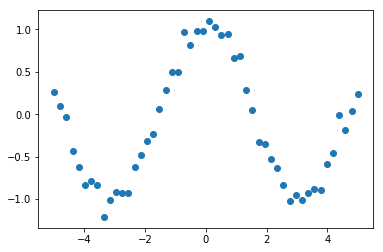

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

x_train = np.linspace(-5, 5, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))
plt.scatter(x_train,y_train)

In [2]:
import tensorflow as tf
from edward.models import Normal
import edward as ed
ed.set_seed(42)
sess = ed.get_session()
tf.global_variables_initializer().run()

W_0 = Normal(mu=tf.zeros([1, 2]), sigma=tf.ones([1, 2]))
W_1 = Normal(mu=tf.zeros([2, 1]), sigma=tf.ones([2, 1]))
b_0 = Normal(mu=tf.zeros(2), sigma=tf.ones(2))
b_1 = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = x_train
y = Normal(mu=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           sigma=0.1)
print(y.get_shape())

qW_0 = Normal(mu=tf.Variable(tf.zeros([1, 2])),
              sigma=tf.nn.softplus(tf.Variable(tf.zeros([1, 2]))))
qW_1 = Normal(mu=tf.Variable(tf.zeros([2, 1])),
              sigma=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))
qb_0 = Normal(mu=tf.Variable(tf.zeros(2)),
              sigma=tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb_1 = Normal(mu=tf.Variable(tf.zeros(1)),
              sigma=tf.nn.softplus(tf.Variable(tf.zeros(1))))



inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples=5)

(50, 1)
Iteration    1 [  0%]: Loss = 2156.964
Iteration  100 [ 10%]: Loss = 240.944
Iteration  200 [ 20%]: Loss = 260.104
Iteration  300 [ 30%]: Loss = 232.815
Iteration  400 [ 40%]: Loss = 235.747
Iteration  500 [ 50%]: Loss = 227.619
Iteration  600 [ 60%]: Loss = 227.307
Iteration  700 [ 70%]: Loss = 226.428
Iteration  800 [ 80%]: Loss = 226.975
Iteration  900 [ 90%]: Loss = 227.117
Iteration 1000 [100%]: Loss = 227.475


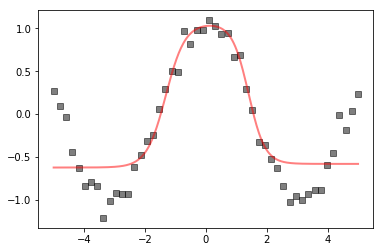

In [3]:
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(tf.constant(inputs), 1)
mus = neural_network(x, qW_0.sample(), qW_1.sample(),
                         qb_0.sample(), qb_1.sample())


outputs = mus.eval()
plt.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
plt.plot(inputs, outputs.T, 'r', lw=2, alpha=0.5, label='posterior draws')